# ＧＸゲームアニメ日株ETF 日足

In [1]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import re
import yfinance as yf

pattern = re.compile(r'(.+)\.T')

symbol = '2640.T'
ticker = yf.Ticker(symbol)

df = ticker.history(period='6mo')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2024-08-14 00:00:00+09:00,2921.0,2948.0,2907.0,2937.0,673,0.0,0.0,0.0
2024-08-15 00:00:00+09:00,2944.0,2969.0,2944.0,2956.0,4940,0.0,0.0,0.0
2024-08-16 00:00:00+09:00,2986.0,3030.0,2982.0,3030.0,1886,0.0,0.0,0.0
2024-08-19 00:00:00+09:00,3030.0,3050.0,3015.0,3020.0,612,0.0,0.0,0.0
2024-08-20 00:00:00+09:00,3055.0,3080.0,3040.0,3075.0,574,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2025-02-07 00:00:00+09:00,3920.0,3920.0,3865.0,3890.0,19253,0.0,0.0,0.0
2025-02-10 00:00:00+09:00,3895.0,3930.0,3875.0,3915.0,5439,0.0,0.0,0.0
2025-02-12 00:00:00+09:00,3950.0,3990.0,3865.0,3885.0,12422,0.0,0.0,0.0


## パラボリック SAR

In [2]:
def psar(ohlc: pd.DataFrame, iaf: float = 0.02, maxaf: float = 0.2) -> dict:
    length = len(ohlc)
    high = ohlc['High'].tolist()
    low = ohlc['Low'].tolist()
    close = ohlc['Close'].tolist()
 
    psar = close[0:len(close)]
    psarbull = [None] * length
    psarbear = [None] * length
 
    bull = True
    af = iaf
    ep = low[0]
    price_high = high[0]
    price_low = low[0]
 
    for i in range(2, length):
        if bull:
            psar[i] = psar[i - 1] + af * (price_high - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (price_low - psar[i - 1])
        reverse = False
 
        if bull:
            if low[i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = price_high
                price_low = low[i]
                af = iaf
        else:
            if high[i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = price_low
                price_high = high[i]
                af = iaf
 
        if not reverse:
            if bull:
                if high[i] > price_high:
                    price_high = high[i]
                    af = min(af + iaf, maxaf)
                if low[i - 1] < psar[i]:
                    psar[i] = low[i - 1]
                if low[i - 2] < psar[i]:
                    psar[i] = low[i - 2]
            else:
                if low[i] < price_low:
                    price_low = low[i]
                    af = min(af + iaf, maxaf)
                if high[i - 1] > psar[i]:
                    psar[i] = high[i - 1]
                if high[i - 2] > psar[i]:
                    psar[i] = high[i - 2]
 
        if bull:
            psarbull[i] = psar[i]
        else:
            psarbear[i] = psar[i]
 
    return {
        'bear': np.array(psarbear, dtype='float64'),
        'bull': np.array(psarbull, dtype='float64'),
    }

## 日足チャートとパラボリック SAR

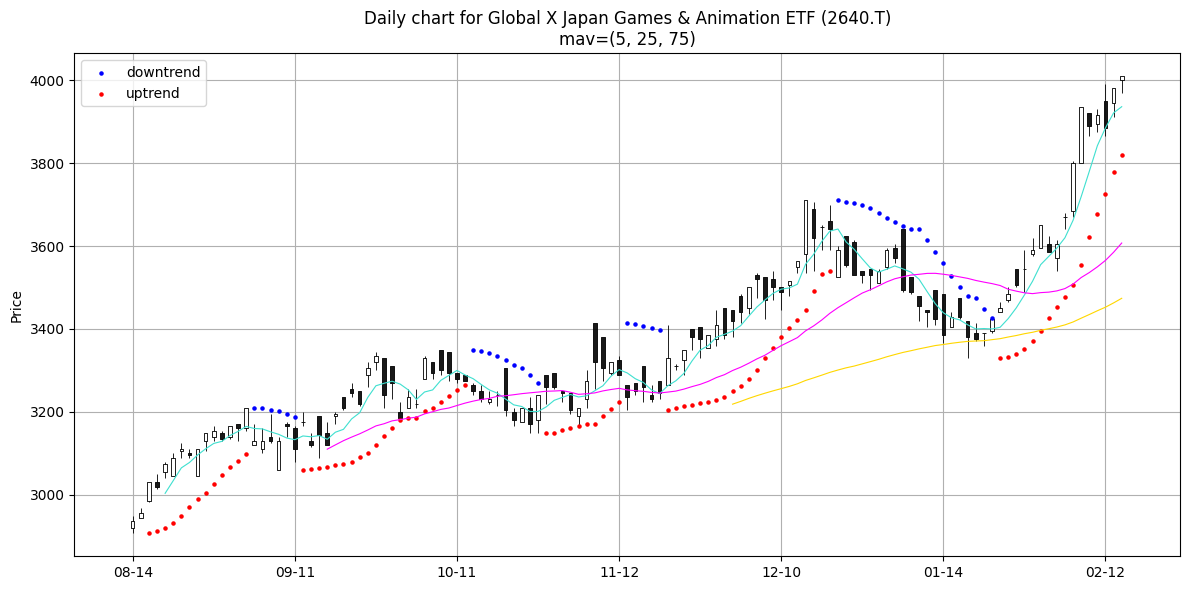

In [3]:
dict_psar = psar(df)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=5,
        color='blue',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=5,
        color='red',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    mav=(5, 25, 75),
    volume=False,
    datetime_format='%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax,
)

try:
    ax.set_title('Daily chart for %s (%s)\nmav=(5, 25, 75)' % (ticker.info['longName'], symbol))
except KeyError:
    ax.set_title('Daily chart for %s\nmav=(5, 25, 75)' % symbol)

ax.grid()
ax.legend(loc='upper left')

plt.tight_layout()

m = pattern.match(symbol)
if m:
    plt.savefig('daily_chart_%s.png' % m.group(1))
else:
    plt.savefig('daily_chart_%s.png' % symbol)

plt.show()

In [4]:
df.tail(2)['Close']

Date
2025-01-20 00:00:00+09:00    3375.0
2025-01-21 00:00:00+09:00    3375.0
Name: Close, dtype: float64

In [5]:
df.tail(2)['Close'].diff()

Date
2025-01-20 00:00:00+09:00    NaN
2025-01-21 00:00:00+09:00    0.0
Name: Close, dtype: float64

In [6]:
df['Close'].rolling(5).mean().tail(2)

Date
2025-01-20 00:00:00+09:00    3400.0
2025-01-21 00:00:00+09:00    3398.0
Name: Close, dtype: float64

In [7]:
df['Close'].rolling(25).mean().tail(2)

Date
2025-01-20 00:00:00+09:00    3517.0
2025-01-21 00:00:00+09:00    3512.4
Name: Close, dtype: float64

In [8]:
df['Close'].rolling(75).mean().tail(2)

Date
2025-01-20 00:00:00+09:00    3371.000000
2025-01-21 00:00:00+09:00    3371.533333
Name: Close, dtype: float64